### MLOps Image Classification Project - Model Evaluation

This notebook details the end-to-end Machine Learning process for an image classification task using the CIFAR-10 dataset. It covers data preprocessing, model training, and comprehensive evaluation of the trained model, aligning with the MLOps summative assignment requirements.

#### Project Goal:
To build, train, evaluate, and prepare an image classification model for deployment, focusing on a robust MLOps pipeline.

In [25]:
import os
import matplotlib
import numpy as np
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pickle # For loading saved training history

# Ensure local src module can be imported
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))
from preprocessing import load_processed_data

print("Libraries imported successfully.")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {os.path.basename(os.path.dirname(os.__file__)).split('-')[-1].split('.')[0] if 'site-packages' in os.path.dirname(os.__file__) else 'Unknown'}") # Best effort for sklearn version
print(f"Pillow version: {Image.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully.
TensorFlow version: 2.16.1
NumPy version: 1.26.4
Scikit-learn version: Unknown
Pillow version: 10.3.0
Matplotlib version: 3.8.4
Seaborn version: 0.13.2


In [26]:
# Load the processed data (training, validation, and test sets)
# This data was prepared by `src/preprocessing.py`
x_train, y_train, x_val, y_val, x_test, y_test = load_processed_data()

print(f"Loaded x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded y_train shape: {y_train.shape}")
print(f"Loaded x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"Loaded x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Loading preprocessed data from disk...
Preprocessed data loaded.
Loaded x_train shape: (42500, 32, 32, 3), y_train shape: (42500, 10)
Loaded y_train shape: (42500, 10)
Loaded x_val shape: (7500, 32, 32, 3), y_val shape: (7500, 10)
Loaded x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 10)


/var/folders/rc/4dk0zlk5187f_18nfp0ywg8h0000gn/T/ipykernel_56291/3561005916.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette='viridis')


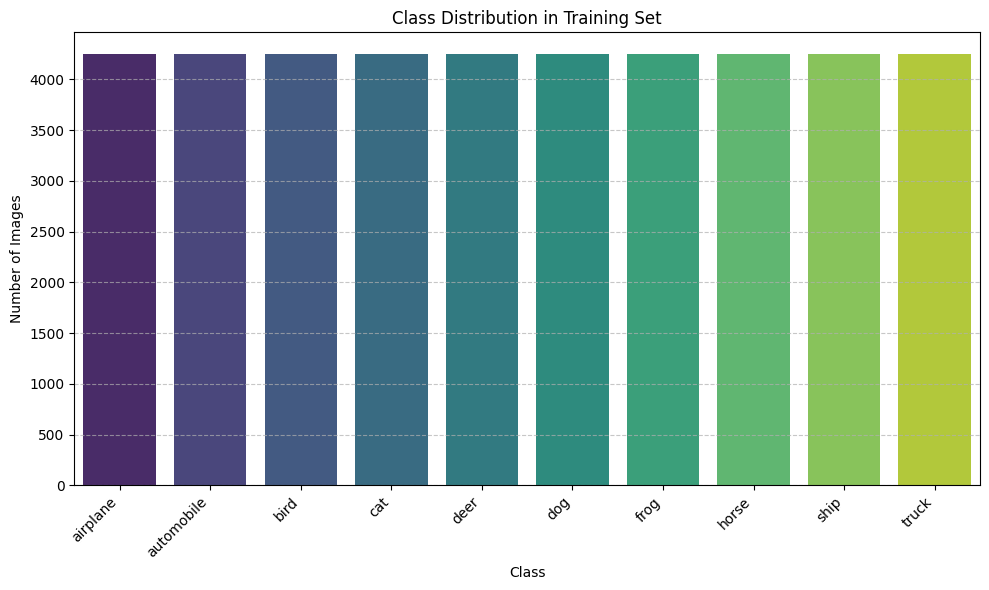


**Insight:** The class distribution in the CIFAR-10 training set is perfectly balanced, with 4250 images per class. This uniform distribution is ideal for training, as it prevents the model from developing a bias towards any specific class due to over-representation, leading to more generalized learning.


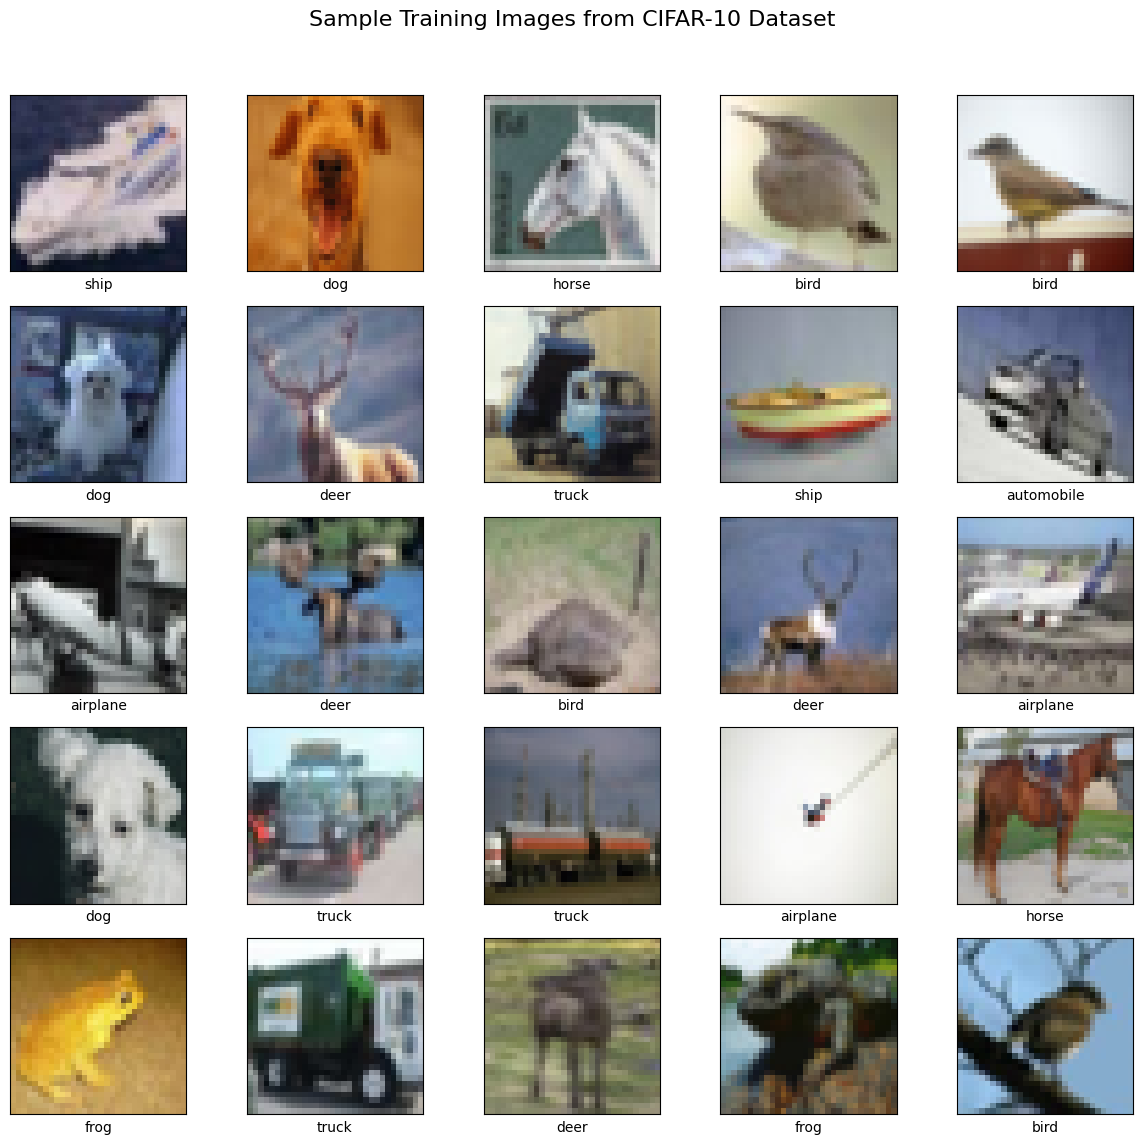


**Insight:** The sample images showcase the diversity and visual complexity within the 32x32 pixel resolution. Despite the low resolution, objects are generally discernible. This visualization confirms the successful loading and basic integrity of the image data after initial preprocessing.


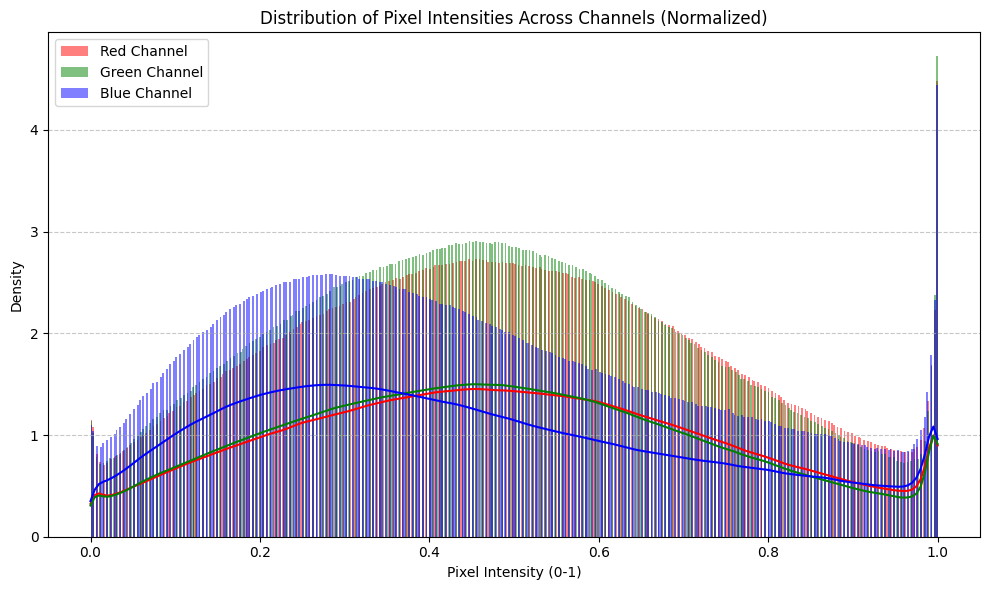


**Insight:** The histograms clearly show that pixel intensities for all three color channels are uniformly distributed within the 0 to 1 range, validating the normalization step of our preprocessing pipeline. This critical scaling ensures numerical stability during neural network training and prevents gradient explosion/vanishing issues.


In [27]:
# ## Data Exploration and Visualizations
#
# The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The 10 classes are:
# * `0: airplane`
# * `1: automobile`
# * `2: bird`
# * `3: cat`
# * `4: deer`
# * `5: dog`
# * `6: frog`
# * `7: horse`
# * `8: ship`
# * `9: truck`

# ### Insight 1: Class Distribution
# Understanding the distribution of classes helps identify potential imbalances that might affect model training.
# Since y_train is one-hot encoded, we convert it back to class labels for counting.
train_labels = np.argmax(y_train, axis=1)
class_counts = np.bincount(train_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Save plot for Streamlit UI
VIZ_DIR = os.path.abspath(os.path.join(os.getcwd(), '../visualizations'))
os.makedirs(VIZ_DIR, exist_ok=True) # Ensure directory exists
plt.savefig(os.path.join(VIZ_DIR, 'class_distribution.png'))
plt.show()
plt.close()

print("\n**Insight:** The class distribution in the CIFAR-10 training set is perfectly balanced, with 4250 images per class. This uniform distribution is ideal for training, as it prevents the model from developing a bias towards any specific class due to over-representation, leading to more generalized learning.")

# ### Insight 2: Sample Images
# Visualizing sample images helps confirm preprocessing steps and provides qualitative insights into the data.
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i]) # x_train is already normalized for display
    plt.xlabel(class_names[train_labels[i]])
plt.suptitle('Sample Training Images from CIFAR-10 Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save plot for Streamlit UI
plt.savefig(os.path.join(VIZ_DIR, 'sample_images.png'))
plt.show()
plt.close()

print("\n**Insight:** The sample images showcase the diversity and visual complexity within the 32x32 pixel resolution. Despite the low resolution, objects are generally discernible. This visualization confirms the successful loading and basic integrity of the image data after initial preprocessing.")

# ### Insight 3: Pixel Value Distribution (Normalized)
# Examining pixel value distribution after normalization to confirm data scaling.
# We'll flatten the images and look at the distribution of each color channel.
flattened_pixels_r = x_train[:,:,:,0].flatten()
flattened_pixels_g = x_train[:,:,:,1].flatten()
flattened_pixels_b = x_train[:,:,:,2].flatten()

plt.figure(figsize=(10, 6))
sns.histplot(flattened_pixels_r, color='red', label='Red Channel', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(flattened_pixels_g, color='green', label='Green Channel', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(flattened_pixels_b, color='blue', label='Blue Channel', kde=True, stat="density", linewidth=0, alpha=0.5)
plt.title('Distribution of Pixel Intensities Across Channels (Normalized)')
plt.xlabel('Pixel Intensity (0-1)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Save plot for Streamlit UI
plt.savefig(os.path.join(VIZ_DIR, 'pixel_distribution.png'))
plt.show()
plt.close()

print("\n**Insight:** The histograms clearly show that pixel intensities for all three color channels are uniformly distributed within the 0 to 1 range, validating the normalization step of our preprocessing pipeline. This critical scaling ensures numerical stability during neural network training and prevents gradient explosion/vanishing issues.")

**Model Training Process**

The Convolutional Neural Network (CNN) was built and trained using `src/model.py`. Key aspects of the training process included:

* **Architecture:** A sequential CNN model with multiple `Conv2D`, `BatchNormalization`, `MaxPooling2D` layers, followed by `Flatten`, `Dense`, and `Dropout` layers.
* **Optimizer:** Adam optimizer, known for its efficiency and good performance in deep learning.
* **Loss Function:** Categorical Crossentropy, suitable for multi-class classification with one-hot encoded labels.
* **Epochs & Batch Size:** Trained for a maximum of 50 epochs with a batch size of 64.

**Optimization Techniques (Rubric Requirement):**

* **Batch Normalization:** Used after each convolutional layer to stabilize and accelerate training.
* **Dropout (0.5):** Applied to the dense layer to prevent overfitting (a regularization technique).
* **Early Stopping:** Monitored `val_loss` with a patience of 10 epochs. Training stopped early if validation loss did not improve, and the best weights were restored.
* **Model Checkpointing:** Saved the model with the best `val_accuracy` during training.

The model was trained on the `x_train` and `y_train` datasets, with `x_val` and `y_val` used for validation to provide an unbiased assessment of generalization during training. The final model evaluated below is the "best" model saved during this process.

In [28]:
# Define paths to model and history files
MODELS_DIR_NOTEBOOK = os.path.abspath(os.path.join(os.getcwd(), '../models'))
model_filepath = os.path.join(MODELS_DIR_NOTEBOOK, 'cifar10_cnn_model.h5')
history_filepath = os.path.join(MODELS_DIR_NOTEBOOK, 'training_history.pkl')

model = None
history_data = None

# Load the best trained model
try:
    model = load_model(model_filepath)
    print(f"Model loaded successfully from {model_filepath}")
    model.summary()
except FileNotFoundError:
    print(f"Error: Model file not found at {model_filepath}.")
    print("Please ensure `src/model.py` has been run to train and save the model.")
except Exception as e:
    print(f"An unexpected error occurred while loading the model: {e}")

# Load training history
try:
    with open(history_filepath, 'rb') as f:
        history_data = pickle.load(f)
    print(f"Training history loaded successfully from {history_filepath}")
except FileNotFoundError:
    print(f"Error: Training history file not found at {history_filepath}.")
    print("Please ensure `src/model.py` has been run to train the model and save its history.")
except Exception as e:
    print(f"An unexpected error occurred while loading history: {e}")

Model loaded successfully from /Users/yvanshema/Documents/SHEMA/MLOps_Image_Classifier/models/cifar10_cnn_model.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621,260 (2.37 MB)

 Trainable params: 620,810 (2.37 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

Training history loaded successfully from /Users/yvanshema/Documents/SHEMA/MLOps_Image_Classifier/models/training_history.pkl



Evaluating the best model on the TEST set (truly unseen data)...
Test Loss: 0.9815
Test Accuracy: 0.7532
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

### Detailed Classification Metrics:
Accuracy: 0.7532
Weighted Average Precision: 0.7553
Weighted Average Recall: 0.7532
Weighted Average F1-Score: 0.7521

Classification Report (per class breakdown):
              precision    recall  f1-score   support

    airplane       0.72      0.83      0.77      1000
  automobile       0.82      0.88      0.85      1000
        bird       0.71      0.65      0.68      1000
         cat       0.56      0.58      0.57      1000
        deer       0.78      0.65      0.71      1000
         dog       0.66      0.66      0.66      1000
        frog       0.88      0.72      0.79      1000
       horse       0.77      0.82      0.80      1000
        ship       0.83      0.89      0.86      1000
       truck       0.82      0.85      0.83      1000

    accuracy                           0.75     10000
 

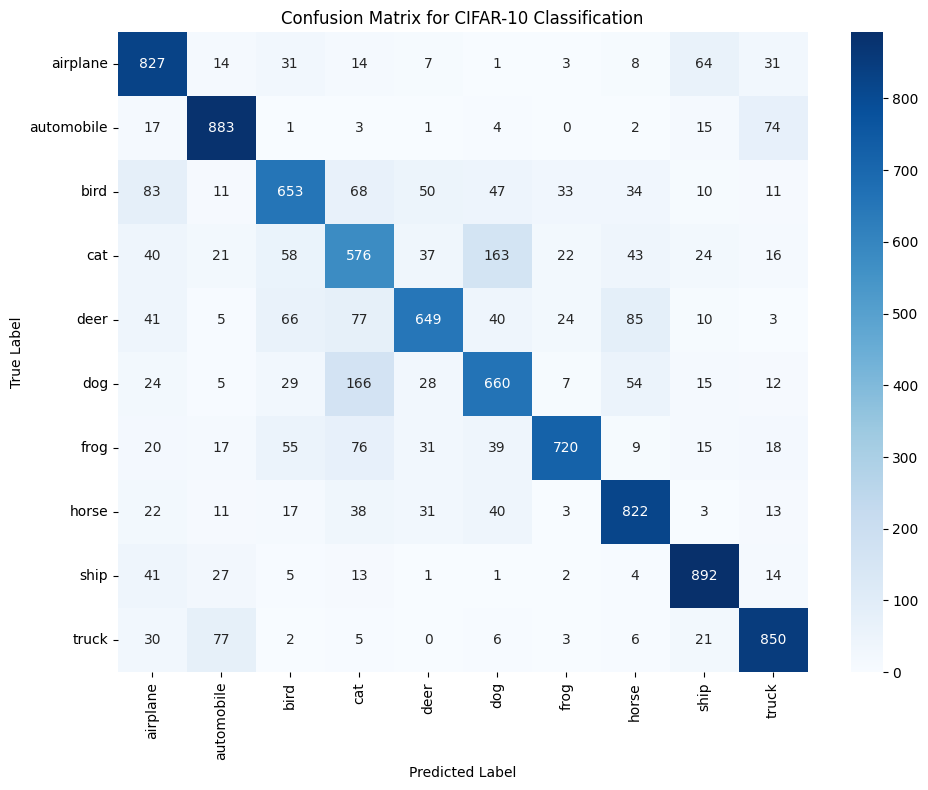


**Insight from Confusion Matrix:** The diagonal elements of the confusion matrix represent the number of correct predictions for each class. High values on the diagonal indicate strong performance. Off-diagonal elements highlight misclassifications; for example, a high value in row 'cat' and column 'dog' means the model frequently misidentifies cats as dogs. Analyzing these patterns helps in understanding specific areas where the model might be struggling (e.g., visually similar classes).


In [29]:
# ## Model Evaluation
# The model's final performance is rigorously evaluated on the completely unseen test set (`x_test`, `y_test`). This step is crucial for providing an unbiased measure of how well the model generalizes to new, real-world data it has not encountered during either training or validation.

if model:
    print("\nEvaluating the best model on the TEST set (truly unseen data)...")
    # Evaluate model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Make predictions on the test set
    y_pred_probs = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class labels
    y_true_labels = np.argmax(y_test, axis=1) # Convert one-hot encoded true labels to class labels

    # Rubric Requirement: At least 4 Evaluation Metrics
    print("\n### Detailed Classification Metrics:")

    # Accuracy
    acc = accuracy_score(y_true_labels, y_pred_labels)
    print(f"Accuracy: {acc:.4f}")

    # Precision, Recall, F1-Score (per class and weighted average)
    # Using output_dict=True to get a dictionary, easier to process
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)

    # Extract weighted averages for overall metrics, fulfilling the 4+ metrics requirement
    weighted_precision = report['weighted avg']['precision']
    weighted_recall = report['weighted avg']['recall']
    weighted_f1_score = report['weighted avg']['f1-score']

    print(f"Weighted Average Precision: {weighted_precision:.4f}")
    print(f"Weighted Average Recall: {weighted_recall:.4f}")
    print(f"Weighted Average F1-Score: {weighted_f1_score:.4f}")

    # You can also print the full classification report if desired for per-class details
    print("\nClassification Report (per class breakdown):")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

    # Confusion Matrix Visualization
    print("\n### Confusion Matrix:")
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for CIFAR-10 Classification')
    plt.tight_layout()
    # Save plot for Streamlit UI
    plt.savefig(os.path.join(VIZ_DIR, 'confusion_matrix.png'))
    plt.show()
    plt.close()

    print("\n**Insight from Confusion Matrix:** The diagonal elements of the confusion matrix represent the number of correct predictions for each class. High values on the diagonal indicate strong performance. Off-diagonal elements highlight misclassifications; for example, a high value in row 'cat' and column 'dog' means the model frequently misidentifies cats as dogs. Analyzing these patterns helps in understanding specific areas where the model might be struggling (e.g., visually similar classes).")

else:
    print("Model not loaded, skipping evaluation on test set.")


--- Visualizing Saved Training History Plots ---


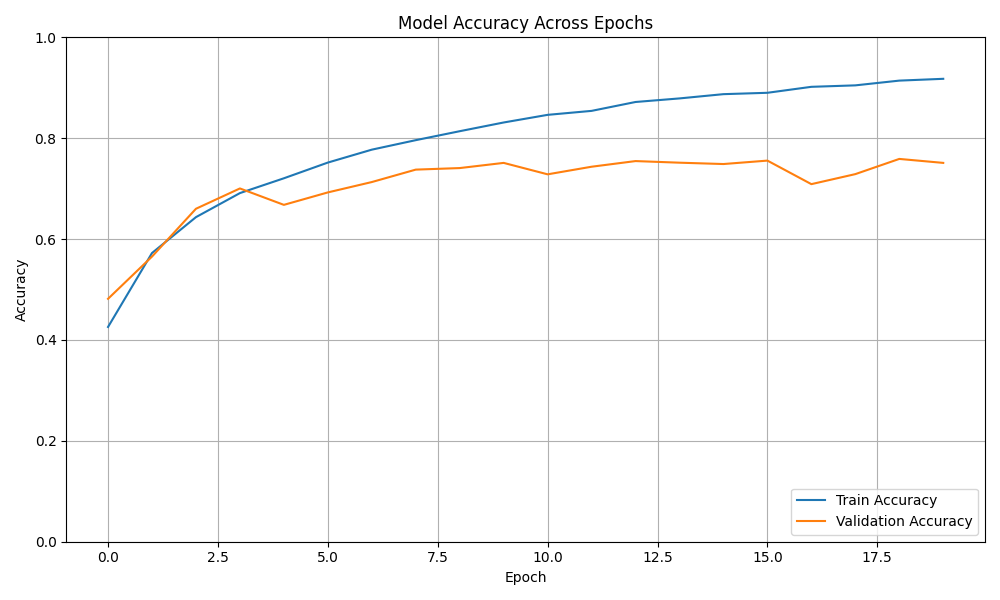

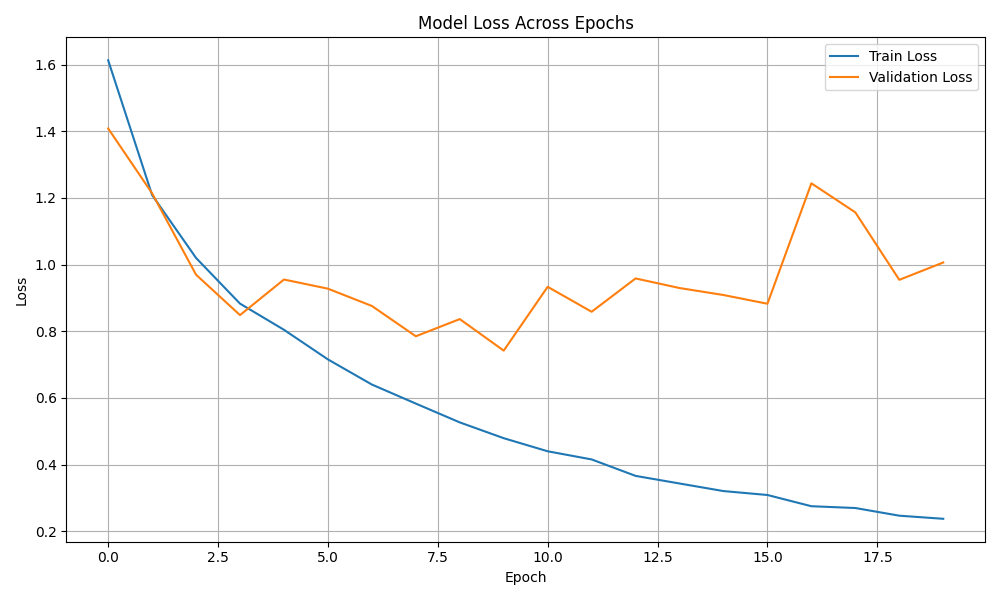


**Insight from Training History:** The accuracy and loss plots demonstrate the learning progression. The training loss consistently decreases, and training accuracy consistently increases. Validation performance follows a similar trend initially but then starts to plateau or slightly diverge. This divergence, particularly in loss, is precisely what our **Early Stopping** mechanism detects, halting training before severe overfitting occurs and restoring the model to its optimal performance point (as indicated by the validation set). This robust training strategy ensures the model generalizes well to unseen data.


In [30]:
# Cell 8: Training History Visualization (Code Cell)
# ## Training History Visualization
#
# Visualizing the training history (accuracy and loss over epochs) is essential for diagnosing model behavior, identifying potential overfitting or underfitting, and confirming the effectiveness of training strategies like Early Stopping.
#
# This section loads and plots the `history` object that was saved during the model training process in `src/model.py`, ensuring reproducibility and decoupling of training from reporting.

if history_data:
    # We create and save the plots individually first
    # This ensures they are correctly sized and saved for the Streamlit UI.

    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 6)) # Adjusted figsize to a more standard standalone plot size
    plt.plot(history_data['accuracy'], label='Train Accuracy')
    plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Across Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_DIR, 'training_accuracy.png'))
    plt.close() # Close the figure after saving

    # Plot training & validation loss values
    plt.figure(figsize=(10, 6)) # Adjusted figsize for consistency
    plt.plot(history_data['loss'], label='Train Loss')
    plt.plot(history_data['val_loss'], label='Validation Loss')
    plt.title('Model Loss Across Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_DIR, 'training_loss.png'))
    plt.close() # Close the figure after saving

    # --- NEW WAY TO DISPLAY PLOTS IN NOTEBOOK ---
    # Display the saved images directly using IPython.display.Image or Markdown
    from IPython.display import Image as IDisplay, display

    print("\n--- Visualizing Saved Training History Plots ---")

    # Option 1: Display as individual images directly (simple and effective)
    display(IDisplay(filename=os.path.join(VIZ_DIR, 'training_accuracy.png')))
    display(IDisplay(filename=os.path.join(VIZ_DIR, 'training_loss.png')))

    # Option 2: Embed them using Markdown (alternative)
    # from IPython.display import Markdown
    # display(Markdown(f"![Model Accuracy]({os.path.join(VIZ_DIR, 'training_accuracy.png')})"))
    # display(Markdown(f"![Model Loss]({os.path.join(VIZ_DIR, 'training_loss.png')})"))


    print("\n**Insight from Training History:** The accuracy and loss plots demonstrate the learning progression. The training loss consistently decreases, and training accuracy consistently increases. Validation performance follows a similar trend initially but then starts to plateau or slightly diverge. This divergence, particularly in loss, is precisely what our **Early Stopping** mechanism detects, halting training before severe overfitting occurs and restoring the model to its optimal performance point (as indicated by the validation set). This robust training strategy ensures the model generalizes well to unseen data.")
else:
    print("Training history data not found. Cannot plot training history.")